# **PyTorch Neural Network Classification**
## 1. Architecture of a classification neural network
> note: check the ```classification_note.md``` to check the overall architecture description of neural neural network

## 2. Make classification data and get it ready
Here, we can use make_circles() method from scikit-learn to generate two circles with different colored dots

In [1]:
from sklearn.datasets import make_circles

# make 2000 samples
n = 3000

# create circles
X, y = make_circles(n, noise=0.3, # a little bit of noise to the dots 
                    random_state=42) # keep random state with fix sample

In [2]:
# let's view the first 5 x and y values
print(f"First 6 X features: \n{X[:5]}")
print(f"First 5 y values: \n{y[:5]}")

First 6 X features: 
[[-0.15007518  0.58809749]
 [-0.01663532 -1.05424758]
 [ 0.58472714  0.66332259]
 [ 0.38307277  0.86319256]
 [-0.50709044 -0.72126271]]
First 5 y values: 
[1 0 1 0 1]


In [3]:
# Make a Dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,-0.150075,0.588097,1
1,-0.016635,-1.054248,0
2,0.584727,0.663323,1
3,0.383073,0.863193,0
4,-0.507090,-0.721263,1


In [4]:
circles.head(10)

,X1,X2,label
0,-0.150075,0.588097,1
1,-0.016635,-1.054248,0
2,0.584727,0.663323,1
3,0.383073,0.863193,0
4,-0.507090,-0.721263,1
5,0.128757,-0.734013,0
6,1.232274,0.252829,0
7,-0.501040,1.104649,1
8,-0.370735,1.617847,0
9,-0.267308,-0.869801,1


In [5]:
# check different labels
circles.label.value_counts()

1    1500
0    1500
Name: label, dtype: int64

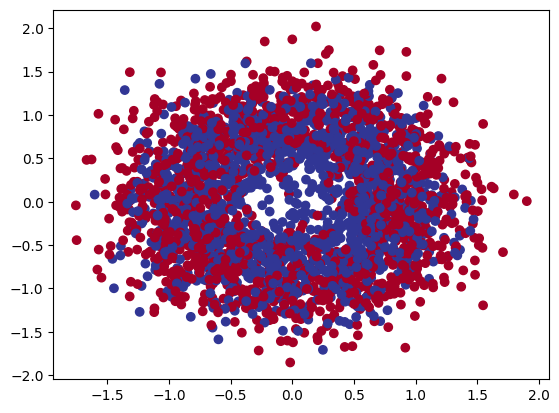

In [6]:
# let's plot the circles

import matplotlib.pyplot as plt
#matplotlib_inline
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

#### 1.1 Input and output shape

In [7]:
# check the shape of our features and labels
X.shape, y.shape

((3000, 2), (3000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for on sample of X: {X_sample} and the same for y: {y_sample}")
print(f"shape for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for on sample of X: [-0.15007518  0.58809749] and the same for y: 1
shape for one sample of X: (2,) and the same for y: ()


#### 1.2 Turn data into tensors and create train and test splits

In [9]:
# Turn data into tensors
# otherwise this cause issues with computations later on

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# view the first five samples
X[:5], y[:5]

(tensor([[-0.1501,  0.5881],
         [-0.0166, -1.0542],
         [ 0.5847,  0.6633],
         [ 0.3831,  0.8632],
         [-0.5071, -0.7213]]),
 tensor([1., 0., 1., 0., 1.]))

In [10]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

In [11]:
# check the status
print(f'X train data: {len(X_train)},\nX test data: {len(X_test)},\ny train data: {len(y_train)},\ny test data: {len(y_test)}')

X train data: 2400,
X test data: 600,
y train data: 2400,
y test data: 600


## 3. Build Model

In [12]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input shape
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes 2 features, produce 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes 5 features, produce 1 feature
    # 3. Define a forward method containing the forword pass computations
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        self.layer_2(self.layer_1(x))

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can also do the same as above using ```nn.Sequential```.

```nn.Sequential``` performs a forward pass computation of the input data through the layers in the order they appear.

In [14]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Make prediction with the model
untrained_preds = model_1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, shape: {y_test.shape}")
print(f"\nLength of 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels: \n{y_test[:10]}")

Length of predictions: 600, shape: torch.Size([600, 1])
Length of test samples: 600, shape: torch.Size([600])

Length of 10 predictions: 
tensor([[0.4220],
        [0.3858],
        [0.3473],
        [0.3021],
        [0.3737],
        [0.3057],
        [0.2885],
        [0.1818],
        [0.4186],
        [0.3047]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels: 
tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 1.])


#### 3.1 Setup loss function and optimizer¶

In [16]:
# create a loss function
# loss_fn = nn.BCELoss() no sigmoid built-in

loss_fn = nn.BCEWithLogitsLoss() # sigmoid built-in

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

**Now let's create evaluation metric**

In [17]:
# Model evaluation matrics and accuracy 
# calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item() # torch.eq() calculate where two tensor a equal
    acc = (correct / len(y_preds)) * 100
    return acc

## 4. Train model
#### 4.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [18]:
# view the first 4 outputs of the forward pass on the test data
y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[0.4220],
        [0.3858],
        [0.3473],
        [0.3021],
        [0.3737]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6040],
        [0.5953],
        [0.5860],
        [0.5749],
        [0.5924]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
# Find the predicted labels (round the prediction prpbabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 1., 1., 0., 0.])

#### 4.2 Building a training and testing loop

In [22]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100


# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build the training and evaluation loop
for epoch in range(epochs):
    ### Trainig
    model_1.train()

    # 1. Forward pass (model output raw logits)
    y_logits = model_1(X_train).squeeze() # squeeze to remove extra `1`
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits to prediction

    # 2. Calculate the loss function
    loss = loss_fn(y_logits, # usnig nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()


    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calcualate loss/accuarcy
        test_loss = loss_fn(test_logits, test_pred)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_pred)

    
    # print out what's happening every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}% |")

Epoch: 0 | Loss: 0.70263, Accuracy: 51.21% | Test Loss: 0.559, Test Accuracy: 45.50% |
Epoch: 10 | Loss: 0.69775, Accuracy: 51.67% | Test Loss: 0.594, Test Accuracy: 46.17% |
Epoch: 20 | Loss: 0.69537, Accuracy: 52.67% | Test Loss: 0.616, Test Accuracy: 49.50% |
Epoch: 30 | Loss: 0.69415, Accuracy: 53.87% | Test Loss: 0.631, Test Accuracy: 50.50% |
Epoch: 40 | Loss: 0.69349, Accuracy: 54.17% | Test Loss: 0.641, Test Accuracy: 50.17% |
Epoch: 50 | Loss: 0.69310, Accuracy: 55.00% | Test Loss: 0.647, Test Accuracy: 50.83% |
Epoch: 60 | Loss: 0.69286, Accuracy: 55.17% | Test Loss: 0.651, Test Accuracy: 51.17% |
Epoch: 70 | Loss: 0.69270, Accuracy: 55.46% | Test Loss: 0.654, Test Accuracy: 50.17% |
Epoch: 80 | Loss: 0.69260, Accuracy: 55.46% | Test Loss: 0.656, Test Accuracy: 50.67% |
Epoch: 90 | Loss: 0.69252, Accuracy: 55.50% | Test Loss: 0.657, Test Accuracy: 49.33% |


#### **Make predictions and evaluate the model**

In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn pyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py','wb') as f:
        f.write(request.content)

helper_functions.py already exist, skipping download


In [24]:
# import different funciton to plto the visualize the mdoel
from helper_functions import plot_predictions, plot_decision_boundary

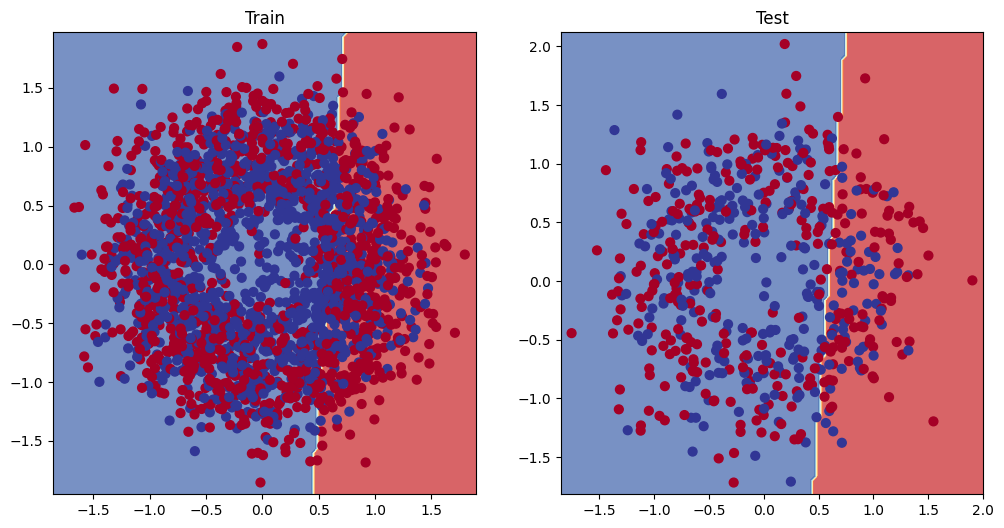

In [25]:
# Plot decision boundaries for train and test set
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(122)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

The model goes upon the underfiting, meaning it's not learning predictive patterns from the data.
- So, How could we imporve this? 

## 5. Improving a model (from a model perspective)
Let's see what happens if we add an extra layer to our model, fit for longer (`epochs=1000` instead of `epochs=100`) and increase the number of hidden units from `5` to `10`.

In [26]:
# Add the layer in the model increase the hidden units
model_v2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10), # added a extra layer
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_v2

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # add extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
        # here I'm going to show a demo for speed up the program
        # let's see what happened with this.
        
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        # this is simillar type of approach
        # z = self.layer_3(self.layer_2(self.layer_1(x)))
        # or we can approach different program


model_v3 = CircleModelV1().to(device)
model_v3

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

Now we've got a model, we'll recreate a loss function and optimizer instance, using the same setting as before.

In [28]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # in this case, we don't require sigmoid on input
optimizer = torch.optim.SGD(model_v3.parameters(), lr=0.1)

This time we'll train for longer (```epochs=1000``` VS ```epochs=100```) and see if it imporves our model

In [29]:
torch.manual_seed(42)

# set the epoch number
epochs= 1000

# set the train and testset to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build the training and test loop
for epoch in range(epochs):
    ## training
    model_v3.train()

    # 1. forward pass (model output row logits)
    y_logits = model_v3(X_train).squeeze() # squeeze to remove extra '1'
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits to prediction

    # 2. calcualte the loss / accuracy fucntion
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds= y_pred)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. optimizer stop
    optimizer.step()


    ## testing
    model_v3.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_v3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate accuracy/loss
        test_loss = loss_fn(test_logits, test_pred)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_pred)

    # print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69608, Accuracy: 51.04% | Test Loss: 0.647, Test Accuracy: 49.83%
Epoch: 100 | Loss: 0.69242, Accuracy: 55.92% | Test Loss: 0.665, Test Accuracy: 47.67%
Epoch: 200 | Loss: 0.69235, Accuracy: 54.67% | Test Loss: 0.660, Test Accuracy: 47.00%
Epoch: 300 | Loss: 0.69234, Accuracy: 54.54% | Test Loss: 0.660, Test Accuracy: 47.50%
Epoch: 400 | Loss: 0.69233, Accuracy: 54.58% | Test Loss: 0.660, Test Accuracy: 47.33%
Epoch: 500 | Loss: 0.69233, Accuracy: 54.37% | Test Loss: 0.660, Test Accuracy: 47.33%
Epoch: 600 | Loss: 0.69233, Accuracy: 54.46% | Test Loss: 0.660, Test Accuracy: 47.50%
Epoch: 700 | Loss: 0.69233, Accuracy: 54.29% | Test Loss: 0.660, Test Accuracy: 47.33%
Epoch: 800 | Loss: 0.69233, Accuracy: 54.37% | Test Loss: 0.660, Test Accuracy: 47.50%
Epoch: 900 | Loss: 0.69233, Accuracy: 54.42% | Test Loss: 0.660, Test Accuracy: 47.67%



What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize.

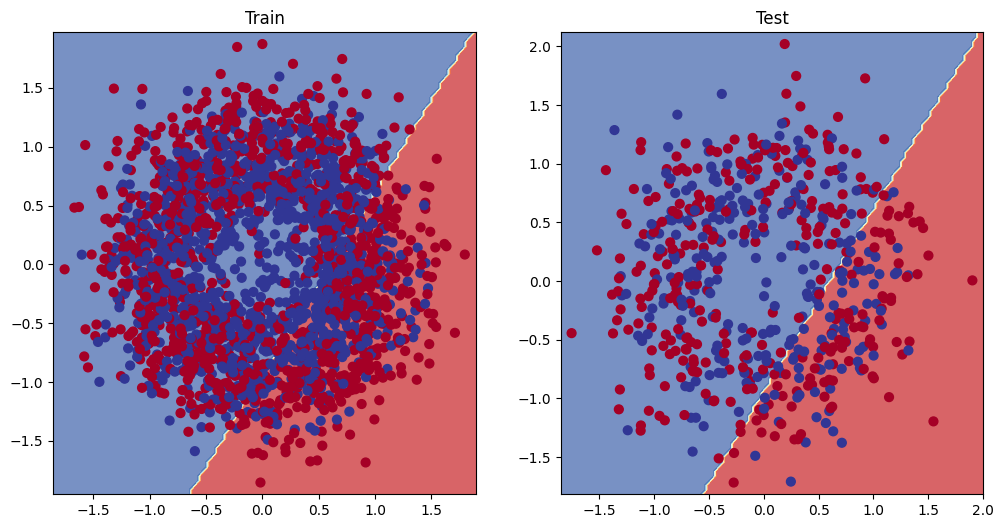

In [30]:
# plot decision bounderies for trainig and test dataset
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Train")
plot_decision_boundary(model_v3, X_train, y_train)
plt.subplot(122)
plt.title("Test")
plot_decision_boundary(model_v3, X_test, y_test)

#### 5.1 Prepareing data to see if our model can model a straight line
Let's create some linear data to see if our model's able to model it and we're not just using a model that can't learn anything.

In [31]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# check the data
print(len(X_regression))
print(f'X regression: {X_regression[:5]}, \nY regression: {y_regression[:5]}')

100
X regression: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]), 
Y regression: tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [32]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(f"X train: {len(X_train_regression)} \ny train: {len(y_train_regression)} \nx test: {len(X_test_regression)} \ny test: {len(y_test_regression)}")

X train: 80 
y train: 80 
x test: 20 
y test: 20


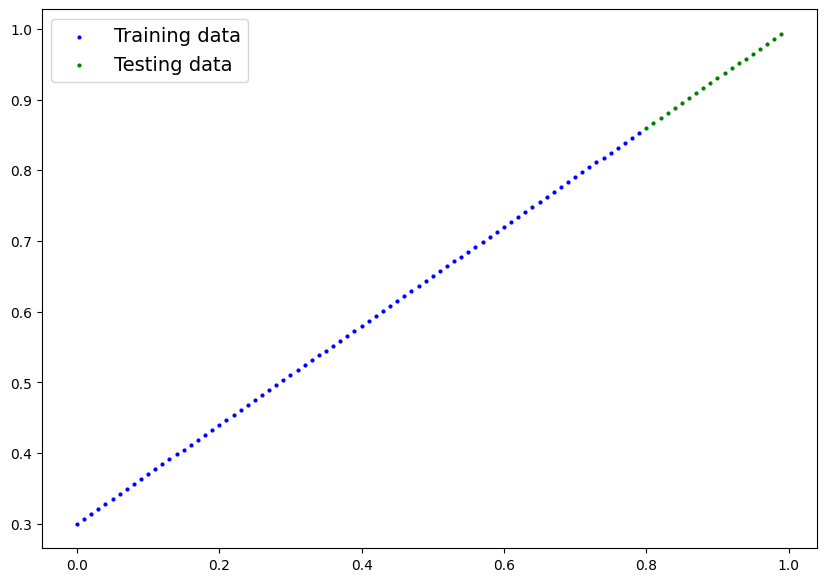

In [33]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

#### 5.2 Adjusting ```model_v3``` to fit a straight line

Now we've got some data, let's recreate ```model_v3``` but with a loss function suited to our regression data.

In [34]:
# Same architecture as model_1 (but using nn.Sequential)
model_v3v1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_v3v1

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

We'll setup the loss function to be ```nn.L1Loss()``` (the same as mean absolute error) and the optimizer to be ```torch.optim.SGD()```

In [35]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_v3v1.parameters(), lr=0.1)

In [36]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_v3v1(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_v3v1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_v3v1(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


And remember, since our model and data are using the target ```device```, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using ```.cpu()``` when we pass it to ```plot_predictions()```

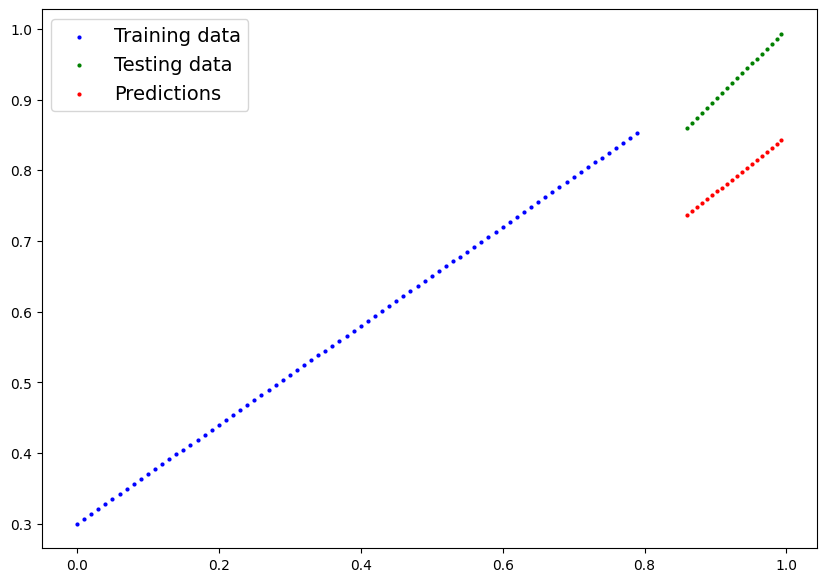

In [37]:
# Trun on evaluation mode

model_v3v1.eval()

# make prediciton (inference)
with torch.inference_mode():
    y_pred = model_v3v1(X_test_regression)

# plot data and prediciton with data on the CPU 
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=y_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_pred.cpu())

### 6. The missing piece: non-linearity
#### 6.1 Recreating non-linear data (red and blue circles)

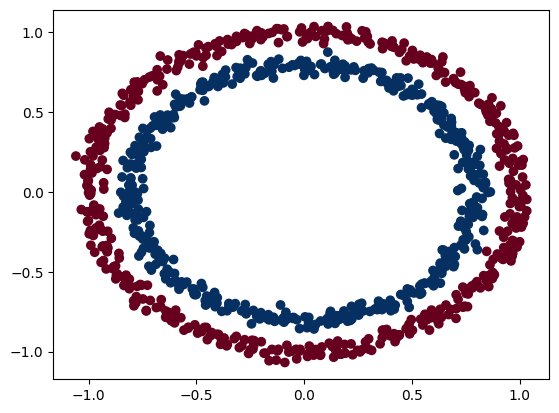

In [38]:
# make a plot data

import matplotlib.pyplot as plt

from sklearn.datasets import make_circles 
n_samples = 1000

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [39]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#### 6.2 Building a model with non-linearity

In [40]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # add a ReLU activation function
        # we can also use sigmoid fucntion
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV2().to(device)
model_4

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

Now we've got a model ready to go, let's create a binary classification ```loss function``` as well as an optimizer.

In [41]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

#### 6.3 Training a model with non-linearity

In [42]:
# fit the model

torch.manual_seed(42)
epochs = 1000

# put all the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    # 1. forward pass
    y_logits = model_4(X_train).squeeze()
    y_prediction = torch.round(torch.sigmoid(y_logits)) # logits -> prediction

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_prediction)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backword
    loss.backward()

    # 5. optimizer step
    optimizer.step()


    # testing
    model_4.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_4(X_test).squeeze()
        test_prediction = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_prediction)

# print out what's happening
if epoch % 10 == 0:
    print(f"Epoch: {epoch} |Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}% |")

In [44]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_preds=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

TypeError: accuracy_fn() got an unexpected keyword argument 'y_pred'